In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Step 2: Preprocess the dataset (directly without graph conversion)
def preprocess(df):
    # Encode categorical columns
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])

    # Normalize the 'amt' and other numeric columns
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())

    # Extract features
    features = df[['amt', 'category', 'city', 'state', 'job']].values

    # Labels (0 for non-fraud, 1 for fraud)
    labels = df['is_fraud'].values

    return torch.tensor(features, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

In [4]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
features, labels = preprocess(df)

In [5]:
# Function to plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

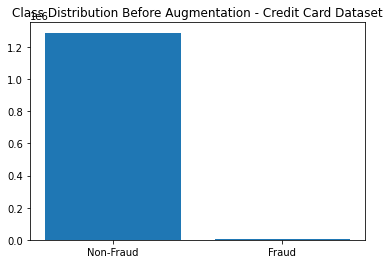

In [6]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation - Credit Card Dataset")

In [7]:
# Define GAN components
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(z))

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [9]:
# GAN parameters
input_size = features.shape[1]  # Number of features
hidden_size = 128
output_size = input_size  # Output size matches input for features
latent_size = 64

In [10]:
# Initialize GAN components
generator = Generator(latent_size, hidden_size, output_size)
discriminator = Discriminator(input_size, hidden_size)

In [11]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [12]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [13]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([2.3957e-03, 6.2278e+00, 4.4526e+02, 2.6677e+01, 2.5117e+02]), Initial Variance: tensor([3.0670e-05, 1.5315e+01, 6.6874e+04, 2.0538e+02, 1.9631e+04]), Initial Std Dev: tensor([5.5381e-03, 3.9134e+00, 2.5860e+02, 1.4331e+01, 1.4011e+02])


In [14]:
num_epochs = 10
target_minority_class = torch.sum(labels == 0)  # We want to match the majority class count
real_data = features[labels == 1]  # Fraud samples (minority class)

In [15]:
# Function to compute R² metric
def compute_r_squared(real_data, generated_data):
    # Compute the mean of the real data
    real_mean = torch.mean(real_data, dim=0)

    # Sum of squared residuals (SSR)
    ssr = torch.sum((real_data - generated_data) ** 2)

    # Total sum of squares (SST)
    sst = torch.sum((real_data - real_mean) ** 2)

    # R² calculation: 1 - SSR / SST
    r_squared = 1 - (ssr / sst)
    return r_squared.item()

In [16]:
# GAN training loop
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break  # Stop training when the minority class is balanced

    # Sample noise for generator input
    z = torch.randn(real_data.size(0), latent_size)

    # Generate fake data
    fake_data = generator(z)

    # Train Discriminator
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data.detach())
    loss_d = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    # Train Generator
    d_fake = discriminator(fake_data)
    loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Print losses at each epoch
    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

    # Update labels and features based on newly generated samples
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    features = torch.cat((features, fake_data))

Epoch [0/10], Loss D: 35.8863525390625, Loss G: 0.803617537021637
Epoch [1/10], Loss D: 27.216157913208008, Loss G: 0.7946385741233826
Epoch [2/10], Loss D: 19.004987716674805, Loss G: 0.7857982516288757
Epoch [3/10], Loss D: 11.599018096923828, Loss G: 0.7769871354103088
Epoch [4/10], Loss D: 4.975782871246338, Loss G: 0.7677026391029358
Epoch [5/10], Loss D: 1.581933617591858, Loss G: 0.7600088715553284
Epoch [6/10], Loss D: 0.6657217144966125, Loss G: 0.7540315389633179
Epoch [7/10], Loss D: 0.6437970399856567, Loss G: 0.7493337988853455
Epoch [8/10], Loss D: 0.645901083946228, Loss G: 0.7458675503730774
Epoch [9/10], Loss D: 0.6482785940170288, Loss G: 0.7433029413223267


In [17]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))  # Generate samples
y_generated = torch.ones(num_generated_samples, dtype=torch.long)  # Label these as fraudulent (minority class)

In [18]:
# Combine generated data with the original data
x_augmented = torch.cat([features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

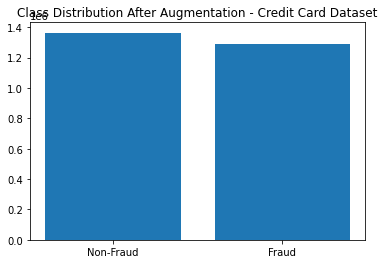

In [19]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation - Credit Card Dataset")

In [20]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

Final Mean: tensor([  0.3160,   3.2628, 217.8306,  13.2389, 123.0163],
       grad_fn=<MeanBackward1>), Final Variance: tensor([9.5202e-02, 1.5887e+01, 8.2117e+04, 2.7296e+02, 2.5291e+04],
       grad_fn=<VarBackward0>), Final Std Dev: tensor([  0.3085,   3.9859, 286.5598,  16.5216, 159.0299],
       grad_fn=<StdBackward0>)


In [23]:
# Compute the final R² metric after the training is complete
final_r_squared = compute_r_squared(real_data, fake_data)
print(f'Final R² between real and generated fraud samples: {final_r_squared}')

Final R² between real and generated fraud samples: -2.9590089321136475
